## **Задание 2:**  </br>
1. собрать собственный датасет для бинарной классификации;
2. взять несколько претрейнов с  imagenet;
3. обучить их на созданном датасете с помощью transfer learning (fine-tuning);
4. сравнить эффективность полученных классификаторов.

In [ ]:
!nvidia-smi

Tue Dec  3 21:32:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
import torch
from PIL import Image

Датасет для бинарной классификации включает изображения **кошек** и **чихуахуа**, был собран самым простым способом — вручную (что было ошибкой...), с последующей обрезкой изображений до квадратной формы и подгонкой размера с помощью кода. Задача — научиться отличать эти два класса на основе изображений.

На первый взгляд, различить кошек и чихуахуа может показаться простой задачей, однако эти животные имеют много схожих черт. </br>
Например, у обеих групп большие выразительные глаза и разнообразные окраски, которые могут быть очень похожи. Как кошки, так и чихуахуа могут быть как длинношерстными, так и короткошерстными, что ещё больше усложняет визуальное различие. Кроме того, у животных могут быть большие или маленькие уши, что также добавляет вариативности в их внешний вид.

#### Предобработка собранного датасета

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/3_сем/CV/dataset.zip'

extract_dir = "/content/dataset"
output_dir = "/content/output"

Mounted at /content/drive


Обрезаем исходные изображения:

In [ ]:
!unzip -qq {zip_path} -d {extract_dir}

def crop_to_square(image):
    width, height = image.size
    min_side = min(width, height)
    left = (width - min_side) // 2
    top = (height - min_side) // 2
    right = left + min_side
    bottom = top + min_side
    return image.crop((left, top, right, bottom))

for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(root, file)

            with Image.open(file_path) as img:
                square_img = crop_to_square(img)
                relative_path = os.path.relpath(root, extract_dir)
                save_dir = os.path.join(output_dir, relative_path)
                os.makedirs(save_dir, exist_ok=True)
                save_path = os.path.join(save_dir, file)
                square_img.save(save_path)

print(f"Все изображения обработаны и сохранены в {output_dir}.")

Все изображения обработаны и сохранены в /content/output.


Приводим картинки к единому размеру:

In [ ]:
input_folder = "output"
output_folder = "resized_images"
target_size = (256, 256)
os.makedirs(output_folder, exist_ok=True)

In [ ]:
for root, _, files in os.walk(input_folder):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(root, file)
            relative_path = os.path.relpath(root, input_folder)
            output_dir = os.path.join(output_folder, relative_path)
            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, file)

            with Image.open(input_path) as img:
                resized_img = img.resize(target_size, Image.Resampling.LANCZOS)
                resized_img.save(output_path)

print(f"Все изображения приведены к размеру {target_size} и сохранены в папке {output_folder}.")

Все изображения приведены к размеру (256, 256) и сохранены в папке resized_images.


Переименуем изображения в каждой из папок исходного архива:

In [ ]:
input_folder = "resized_images"
output_folder = "new_dataset"
photo_number = 1

In [ ]:
for root, _, files in os.walk(input_folder):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            new_name = f"photo_{photo_number}{os.path.splitext(file)[1]}"
            input_path = os.path.join(root, file)

            relative_path = os.path.relpath(root, input_folder)
            output_dir = os.path.join(output_folder, relative_path)
            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, new_name)
            os.rename(input_path, output_path)
            photo_number += 1

print(f"Все изображения переименованы и сохранены в папке {output_folder}.")

Все изображения переименованы и сохранены в папке new_dataset.


Закрепим seed:

In [ ]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(123456)

Укажем путь до датасета и получим пути до всех изображений:

In [ ]:
dataset_path = '/content/new_dataset'

image_paths_cat = glob(os.path.join(dataset_path, '**', 'cat', '*.png'), recursive=True)
image_paths_chihi = glob(os.path.join(dataset_path, '**', 'chihi', '*.png'), recursive=True)

Датасет сбалансирован:

In [ ]:
len(image_paths_cat), len(image_paths_chihi)

(600, 600)

Визуализируем по 2 изображения из каждого класса:

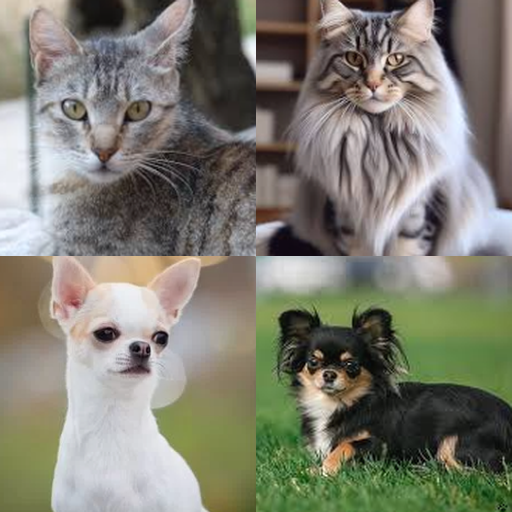

In [ ]:
img1 = cv2.imread(image_paths_cat[0])[:,:,::-1]
img2 = cv2.imread(image_paths_cat[1])[:,:,::-1]

img3 = cv2.imread(image_paths_chihi[0])[:,:,::-1]
img4 = cv2.imread(image_paths_chihi[1])[:,:,::-1]

top_row = np.concatenate([img1, img2], axis=1)
bottom_row = np.concatenate([img3, img4], axis=1)

final_img = np.concatenate([top_row, bottom_row], axis=0)
Image.fromarray(final_img)

#### SVM

Произведем кодирование изображения в векторное представление:

In [ ]:
def get_image_feature(image_path, resolution=(128, 128)):
  # откроем изображение, переведем в монохромный режим и отмасштабируем
  image_rgb = cv2.imread(image_path)
  image = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, resolution)

  # получим hog-дескриптор
  hog = cv2.HOGDescriptor()
  feature = hog.compute(image, winStride=(8, 8), padding=(0, 0))

  histogram = cv2.calcHist([image_rgb], [0, 1, 2], None, (16, 16, 16), [0, 256, 0, 256, 0, 256])
  cv2.normalize(histogram, histogram)
  feature = np.concatenate([feature, histogram.flatten()], axis=0)
  return feature

Разделим на обучающую и тестовую выборки:

In [ ]:
# получим пары (feature, label), label=0: wo mask, label=1: w mask
dataset = [(get_image_feature(image_path), 0) for image_path in image_paths_chihi] + \
          [(get_image_feature(image_path), 1) for image_path in image_paths_cat]
# перемешаем датасет
random.shuffle(dataset)

# разобьем на 2 части: train и test
dataset_train = dataset[:int(0.8*len(dataset))]
dataset_train_features = [el[0] for el in dataset_train]
dataset_train_labels = [el[1] for el in dataset_train]

dataset_test  = dataset[int(0.8*len(dataset)):]
dataset_test_features = [el[0] for el in dataset_test]
dataset_test_labels = [el[1] for el in dataset_test]

print(len(dataset_train), len(dataset_test))

960 240


Инициализируем SVM:

In [ ]:
model = SVC(kernel='linear')
model.fit(dataset_train_features, dataset_train_labels)

SVC(kernel='linear')

Посмотрим на результаты классификации на тренировочной выборке:

In [ ]:
predictions = model.predict(dataset_train_features)
print(classification_report(dataset_train_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       469
           1       1.00      1.00      1.00       491

    accuracy                           1.00       960
   macro avg       1.00      1.00      1.00       960
weighted avg       1.00      1.00      1.00       960



Посмотрим на результаты классификации на тестовой выборке:

In [ ]:
predictions_test = model.predict(dataset_test_features)
print(classification_report(dataset_test_labels, predictions_test))

              precision    recall  f1-score   support

           0       0.77      0.73      0.75       131
           1       0.70      0.74      0.72       109

    accuracy                           0.74       240
   macro avg       0.74      0.74      0.74       240
weighted avg       0.74      0.74      0.74       240



Отобразим ROC-кривую:

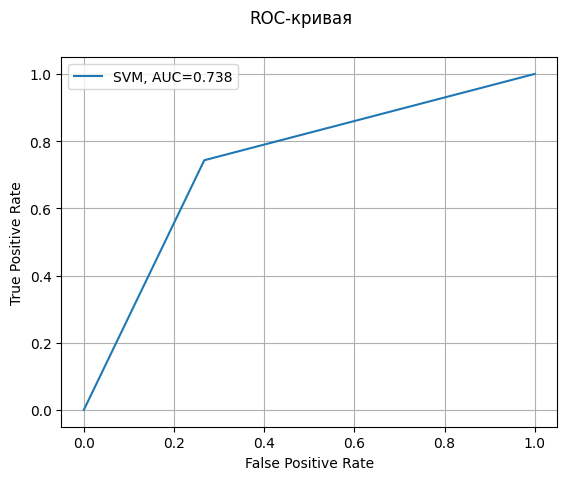

In [ ]:
fpr_svm, tpr_svm, _ = metrics.roc_curve(dataset_test_labels, predictions_test)
auc_svm = round(metrics.roc_auc_score (dataset_test_labels, predictions_test), 4)
plt.plot(fpr_svm, tpr_svm, label="SVM, AUC=" + str(auc_svm))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('ROC-кривая')
plt.grid(True)
plt.legend()
plt.show()

Получаем неплохой результат для baseline.

#### VGG19

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report
from tqdm import tqdm
import torch
import torchvision
from torchvision.models import vgg19
import torchvision.transforms as transforms

In [ ]:
batch_size = 32
n_epochs = 15
device = 'cuda:0'

model = vgg19(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Linear(25088, 1)

model.to(device);

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 82.9MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
transform = transforms.Compose([transforms.Resize((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

dataset = torchvision.datasets.ImageFolder(root='/content/new_dataset', transform=transform)

valid_size = int(len(dataset) * 0.1)
train_set, valid_set = torch.utils.data.random_split(dataset, (len(dataset)-valid_size, valid_size))
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
for epoch in range(1, n_epochs+1):
    train_loss = []
    for batch_i, (data, target) in enumerate(tqdm(train_dataloader)):
        data, target = data.to(device), target.to(device).unsqueeze(1).float()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()

    with torch.no_grad():
        model.eval()
        val_loss = []
        for batch_i, (data, target) in enumerate(valid_dataloader):
            data, target = data.to(device), target.to(device).unsqueeze(1)
            output = model(data)
            loss = criterion(output, target.float())
            val_loss.append(loss.item())

        print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')

100%|██████████| 34/34 [00:08<00:00,  4.01it/s]


Epoch 1, train loss: 0.3450, valid loss: 0.1901.


100%|██████████| 34/34 [00:03<00:00,  9.44it/s]


Epoch 2, train loss: 0.2062, valid loss: 0.4202.


100%|██████████| 34/34 [00:04<00:00,  8.15it/s]


Epoch 3, train loss: 0.1443, valid loss: 0.3155.


100%|██████████| 34/34 [00:05<00:00,  6.55it/s]


Epoch 4, train loss: 0.1042, valid loss: 0.2282.


100%|██████████| 34/34 [00:03<00:00,  9.63it/s]


Epoch 5, train loss: 0.0802, valid loss: 0.2572.


100%|██████████| 34/34 [00:03<00:00,  9.24it/s]


Epoch 6, train loss: 0.0728, valid loss: 0.2451.


100%|██████████| 34/34 [00:05<00:00,  5.74it/s]


Epoch 7, train loss: 0.0548, valid loss: 0.2568.


100%|██████████| 34/34 [00:03<00:00,  9.66it/s]


Epoch 8, train loss: 0.0569, valid loss: 0.2098.


100%|██████████| 34/34 [00:03<00:00,  9.55it/s]


Epoch 9, train loss: 0.0469, valid loss: 0.2177.


100%|██████████| 34/34 [00:04<00:00,  7.05it/s]


Epoch 10, train loss: 0.0418, valid loss: 0.2158.


100%|██████████| 34/34 [00:03<00:00,  8.68it/s]


Epoch 11, train loss: 0.0431, valid loss: 0.2049.


100%|██████████| 34/34 [00:03<00:00,  9.62it/s]


Epoch 12, train loss: 0.0411, valid loss: 0.2242.


100%|██████████| 34/34 [00:04<00:00,  8.08it/s]


Epoch 13, train loss: 0.0327, valid loss: 0.2614.


100%|██████████| 34/34 [00:05<00:00,  6.46it/s]


Epoch 14, train loss: 0.0322, valid loss: 0.2274.


100%|██████████| 34/34 [00:03<00:00,  9.71it/s]


Epoch 15, train loss: 0.0308, valid loss: 0.2742.


In [ ]:
model.to(device)
model.eval()
pred_list = []; y_list = []
for x, y in valid_dataloader:
    with torch.no_grad():
        x = x.to(device)
        y = y.float().to(device)
        output = model(x)
        pred = torch.sigmoid(output)
        pred = pred.cpu().detach().numpy()
        for i in range(pred.shape[0]):
            pred_list.append(pred[i][0])
            y_list.append(int(y[i].item()))

model_prs = []
for model_pr, true_pr in zip(pred_list, y_list):
    model_pr = 1 if model_pr >= 0.5 else 0
    model_prs.append(model_pr)

Посмотрим на результаты классификации на тестовой выборке:

In [ ]:
print(classification_report(np.array(y_list), np.array(model_prs)))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93        63
           1       0.90      0.95      0.92        57

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.92       120
weighted avg       0.93      0.93      0.93       120



Отобразим ROC-кривую:

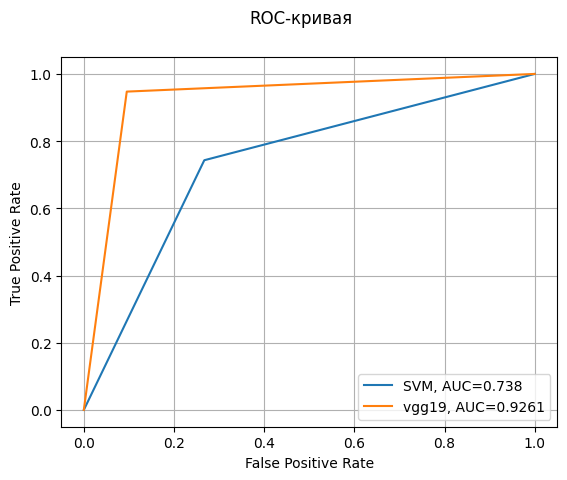

In [ ]:
fpr_cnn, tpr_cnn, _ = metrics.roc_curve(np.array(y_list), np.array(model_prs))
auc_cnn = round(metrics.roc_auc_score(np.array(y_list), np.array(model_prs)), 4)
plt.plot(fpr_svm, tpr_svm, label="SVM, AUC=" + str(auc_svm))
plt.plot(fpr_cnn, tpr_cnn, label="vgg19, AUC=" + str(auc_cnn))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('ROC-кривая')
plt.grid(True)
plt.legend()
plt.show()

Получаем хороший результат относительно baseline.

#### ResNet50

In [ ]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms, datasets, models
from tqdm import tqdm
import numpy as np

In [ ]:
batch_size = 64
n_epochs = 10
device = 'cuda:0'

model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 1)
model.to(device)

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

dataset = torchvision.datasets.ImageFolder(root='/content/new_dataset', transform=transform)

valid_size = int(len(dataset) * 0.1)
train_set, valid_set = torch.utils.data.random_split(dataset, (len(dataset)-valid_size, valid_size))

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.01)

In [ ]:
for epoch in range(1, n_epochs+1):
    train_loss = []
    model.train()
    for batch_i, (data, target) in enumerate(tqdm(train_dataloader)):
        data, target = data.to(device), target.to(device).unsqueeze(1).float()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()

    with torch.no_grad():
        model.eval()
        val_loss = []
        for batch_i, (data, target) in enumerate(valid_dataloader):
            data, target = data.to(device), target.to(device).unsqueeze(1)
            output = model(data)
            loss = criterion(output, target.float())
            val_loss.append(loss.item())

    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')

100%|██████████| 17/17 [00:11<00:00,  1.48it/s]


Epoch 1, train loss: 0.6741, valid loss: 0.6490.


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch 2, train loss: 0.6120, valid loss: 0.5873.


100%|██████████| 17/17 [00:07<00:00,  2.20it/s]


Epoch 3, train loss: 0.5500, valid loss: 0.5282.


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch 4, train loss: 0.4962, valid loss: 0.4768.


100%|██████████| 17/17 [00:07<00:00,  2.15it/s]


Epoch 5, train loss: 0.4470, valid loss: 0.4344.


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch 6, train loss: 0.4137, valid loss: 0.3987.


100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


Epoch 7, train loss: 0.3845, valid loss: 0.3679.


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch 8, train loss: 0.3492, valid loss: 0.3450.


100%|██████████| 17/17 [00:08<00:00,  2.04it/s]


Epoch 9, train loss: 0.3335, valid loss: 0.3206.


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch 10, train loss: 0.3058, valid loss: 0.3035.


In [ ]:
model.to(device)
model.eval()
pred_list = []
y_list = []
with torch.no_grad():
    for x, y in valid_dataloader:
        x = x.to(device)
        y = y.float().to(device)
        output = model(x)
        pred = torch.sigmoid(output)
        pred = pred.cpu().detach().numpy()
        for i in range(pred.shape[0]):
            pred_list.append(pred[i][0])
            y_list.append(int(y[i].item()))

model_prs = [1 if model_pr >= 0.5 else 0 for model_pr in pred_list]

Посмотрим на результаты классификации на тестовой выборке:

In [ ]:
print(classification_report(np.array(y_list), np.array(model_prs)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        56
           1       1.00      0.97      0.98        64

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



Отобразим ROC-кривую:

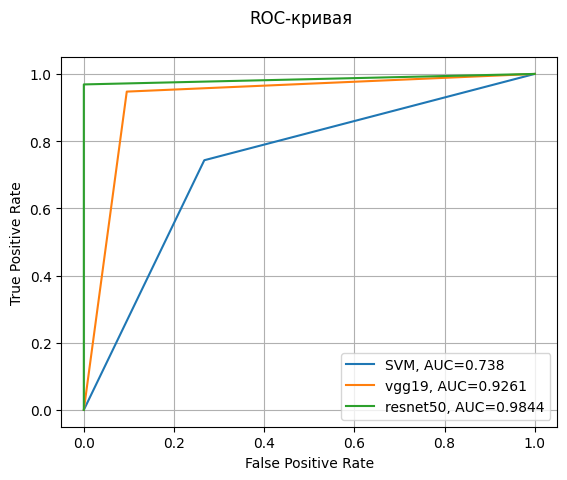

In [ ]:
fpr_resnet50, tpr_resnet50, _ = metrics.roc_curve(np.array(y_list), np.array(model_prs))
auc_resnet50 = round(metrics.roc_auc_score(np.array(y_list), np.array(model_prs)), 4)
plt.plot(fpr_svm, tpr_svm, label="SVM, AUC=" + str(auc_svm))
plt.plot(fpr_cnn, tpr_cnn, label="vgg19, AUC=" + str(auc_cnn))
plt.plot(fpr_resnet50, tpr_resnet50, label="resnet50, AUC=" + str(auc_resnet50))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('ROC-кривая')
plt.grid(True)
plt.legend()
plt.show()

Получаем отличный результат, близкий к 1.

#### DenseNet121

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

batch_size = 16
n_epochs = 10
device = 'cuda:0'

model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Linear(model.classifier.in_features, 1)

model.to(device)

print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 121MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

dataset = torchvision.datasets.ImageFolder(root='/content/new_dataset', transform=transform)

valid_size = int(len(dataset) * 0.1)
train_set, valid_set = torch.utils.data.random_split(dataset, (len(dataset)-valid_size, valid_size))
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
for epoch in range(1, n_epochs+1):
    train_loss = []
    for batch_i, (data, target) in enumerate(tqdm(train_dataloader)):
        data, target = data.to(device), target.to(device).unsqueeze(1).float()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()

    with torch.no_grad():
        model.eval()
        val_loss = []
        for batch_i, (data, target) in enumerate(valid_dataloader):
            data, target = data.to(device), target.to(device).unsqueeze(1)
            output = model(data)
            loss = criterion(output, target.float())
            val_loss.append(loss.item())

        print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')

100%|██████████| 68/68 [00:09<00:00,  7.40it/s]


Epoch 1, train loss: 0.7127, valid loss: 0.6246.


100%|██████████| 68/68 [00:07<00:00,  8.83it/s]


Epoch 2, train loss: 0.5509, valid loss: 0.4846.


100%|██████████| 68/68 [00:09<00:00,  6.86it/s]


Epoch 3, train loss: 0.4292, valid loss: 0.3920.


100%|██████████| 68/68 [00:11<00:00,  5.96it/s]


Epoch 4, train loss: 0.3443, valid loss: 0.3234.


100%|██████████| 68/68 [00:05<00:00, 11.97it/s]


Epoch 5, train loss: 0.2829, valid loss: 0.2709.


100%|██████████| 68/68 [00:08<00:00,  7.89it/s]


Epoch 6, train loss: 0.2377, valid loss: 0.2346.


100%|██████████| 68/68 [00:05<00:00, 11.93it/s]


Epoch 7, train loss: 0.2048, valid loss: 0.2049.


100%|██████████| 68/68 [00:08<00:00,  8.08it/s]


Epoch 8, train loss: 0.1776, valid loss: 0.1833.


100%|██████████| 68/68 [00:05<00:00, 11.88it/s]


Epoch 9, train loss: 0.1566, valid loss: 0.1641.


100%|██████████| 68/68 [00:07<00:00,  8.94it/s]


Epoch 10, train loss: 0.1396, valid loss: 0.1487.


In [ ]:
model.to(device)
model.eval()
pred_list = []
y_list = []
for x, y in valid_dataloader:
    with torch.no_grad():
        x = x.to(device)
        y = y.float().to(device)
        output = model(x)
        pred = torch.sigmoid(output)
        pred = pred.cpu().detach().numpy()
        for i in range(pred.shape[0]):
            pred_list.append(pred[i][0])
            y_list.append(int(y[i].item()))

model_prs = []
for model_pr, true_pr in zip(pred_list, y_list):
    model_pr = 1 if model_pr >= 0.5 else 0
    model_prs.append(model_pr)

Посмотрим на результаты классификации на тестовой выборке:

In [ ]:
print(classification_report(np.array(y_list), np.array(model_prs)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        68
           1       0.98      0.98      0.98        52

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



Отобразим ROC-кривую:

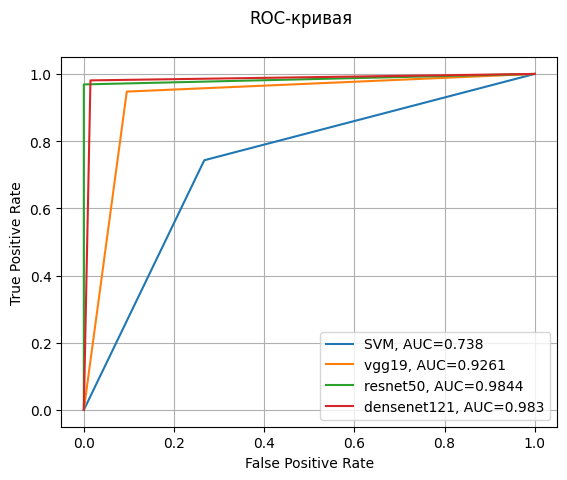

In [ ]:
fpr_densenet121, tpr_densenet121, _ = metrics.roc_curve(np.array(y_list), np.array(model_prs))
auc_densenet121 = round(metrics.roc_auc_score(np.array(y_list), np.array(model_prs)), 4)
plt.plot(fpr_svm, tpr_svm, label="SVM, AUC=" + str(auc_svm))
plt.plot(fpr_cnn, tpr_cnn, label="vgg19, AUC=" + str(auc_cnn))
plt.plot(fpr_resnet50, tpr_resnet50, label="resnet50, AUC=" + str(auc_resnet50))
plt.plot(fpr_densenet121, tpr_densenet121, label="densenet121, AUC=" + str(auc_densenet121))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('ROC-кривая')
plt.grid(True)
plt.legend()
plt.show()

Результат блтзок к результату при использовании ResNet50.

Вывод: ResNet50 и DenseNet121 показали наилучшие результаты с почти одинаковыми значениями AUC, что делает их наиболее подходящими для этой задачи.
VGG19 также является хорошим вариантом, но её эффективность ниже.
SVM значительно уступает глубоким нейросетям.